<div style="text-align: justify; text-justify: inter-word;">

# Smart Grid Stability Prediction

The emergence of new renewable energy sources is rapidly transforming the structure of electrical grid distribution. Historically, the energy sector heavily relied on a small number of producers, primarily focused on fossil fuels, who supplied energy in a one-way fashion to consumers. However, the current landscape has witnessed a significant shift. Now, both households and businesses not only consume energy but also have the ability to generate and sell it. This is often achieved through the installation of solar panels on rooftops or within property gardens, for instance. This transformative development has resulted in a bidirectional flow of energy within the grid, introducing a more intricate challenge in managing the balance of supply and demand.

Within these so-called 'smart grids,' the primary goal is to comprehensively assess and proactively manage disruptions and fluctuations in energy production and consumption introduced by all the participants within the system. This approach relies not only on technical considerations but also on the way in which participants adapt to variations in energy prices.

Researchers in this field are primarily focused on Decentral Smart Grid Control (DSGC) systems. This methodology hinges on monitoring the electrical grid frequency (AC frequency) to gauge the current network power balance, enabling the derivation of an appropriate energy price.

The mathematical model for DSGC is designed to pinpoint grid instability within a reference 4-node star architecture, consisting of one supply source and three consumption nodes. The model takes into account several key features:

1. Total power balance, which includes the nominal power produced or consumed at each grid node.
2. The response time of participants to adjust their consumption and/or production in reaction to price changes.
3. Energy price elasticity which is a measure of how much the quantity of electricity consumed changes in response to a change in its price.

### Problematic

As with all complex mathematical models based on differential equations, certain assumptions and simplifications are necessary to solve them. However, these simplifications can lead to challenges when it comes to accurately determining grid stability. (For more details on these issues, you can refer to the dataset papers.)

And so our objective now is to use machine/deep learning models and the nodes' data to approximate the DSGC mathematical model and learn how to make accurate grid stability predictions based on these given features.

</div>


## About the Dataset

The original dataset used in this study (can be found [here](https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data)) contains 10,000 observations from simulations of grid stability for a reference 4-node star network, the data is composed of the following fields :

* 'tau1' to 'tau4': the reaction time of each network participant, which ranges between 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);
* 'p1' to 'p4': nominal power produced by supplier node ('p1' which is positive) or power consumed by each network participant ('p2' to 'p4'), ranging from -2.0 to -0.5 for consumers. (total power consumed equals total power generated => p1 = - (p2 + p3 + p4));
* 'g1' to 'g4': price elasticity coefficient ('gamma') for each network participant, ranging 0.05 to 1.00 ('g1' for the supplier node, 'g2' to 'g4' for the consumer nodes);
* 'stab': the maximum real part of the characteristic differential equation root (if positive, the system is linearly unstable; if negative it's linearly stable);
* 'stabf': a categorical label ('stable' or 'unstable') derived from 'stab' value.

Due the symetricity of the data, it can be augmented into up to 60,000 observations (as the three consumer nodes can be interchanged) which results in the used [kaggle dataset](https://www.kaggle.com/datasets/pcbreviglieri/smart-grid-stability).

As the 'stabf' field is directly derived from the 'stab' value ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), and because we are considering a classification problem here we will keep the 'stabf' variable as our target and drop the 'stab' field.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("./smart_grid_stability_augmented.csv")

In [3]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [4]:
data.shape

(60000, 14)

In [5]:
data.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243,0.036917
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028,-0.080760
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497,-0.015557
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007,0.017142
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490,0.044878
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982,0.109403


It is worth noting that the nominal power columns 'p1' to 'p4' likely undergo scaling (normalization), given their notably small values, which may not align with actual grid power magnitudes.

Text(0, 0.5, 'Percentage (%)')

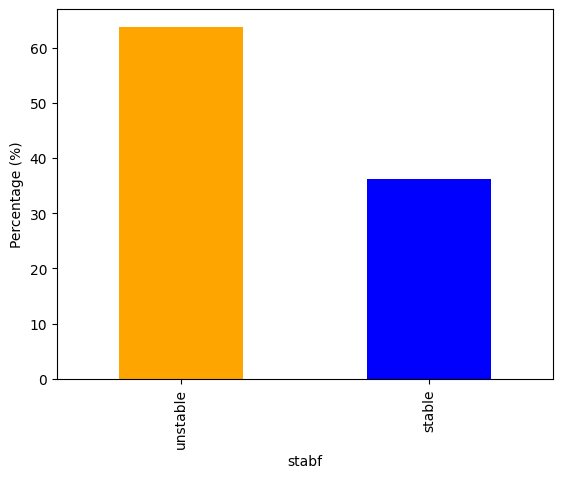

In [6]:
# Check if target classes are balanced
(data["stabf"].value_counts(normalize=True)*100).plot(kind='bar', color=['orange', 'blue'])
plt.ylabel("Percentage (%)")

In [7]:
# Data does not contain any missing values
data.isna().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

In [8]:
# all the fields are of type float except for "stabf"
print("Numerical columns count:", (data.dtypes == "float64").sum())
print("Categorical columns count:", (data.dtypes == "O").sum())

Numerical columns count: 13
Categorical columns count: 1


#### Observation

We observe that the dataset is free of missing values. However, an imbalance exists in the distribution of our target 'stabf' classes, with unstable cases comprising a higher proportion (~63%), while this presents a noticeable asymmetry, it remains manageable for our study.

## Exploratory Data Analysis

In [9]:
# Encode the "stabf" variable classes
data["stabf"] = data["stabf"].map({"stable": 0, "unstable": 1})

In [10]:
df = data.copy()
target = data["stabf"]
features = data.drop(["stabf", "stab"], axis=1)

### Features distribution

Let's see how our features behave based on the grid stability state.

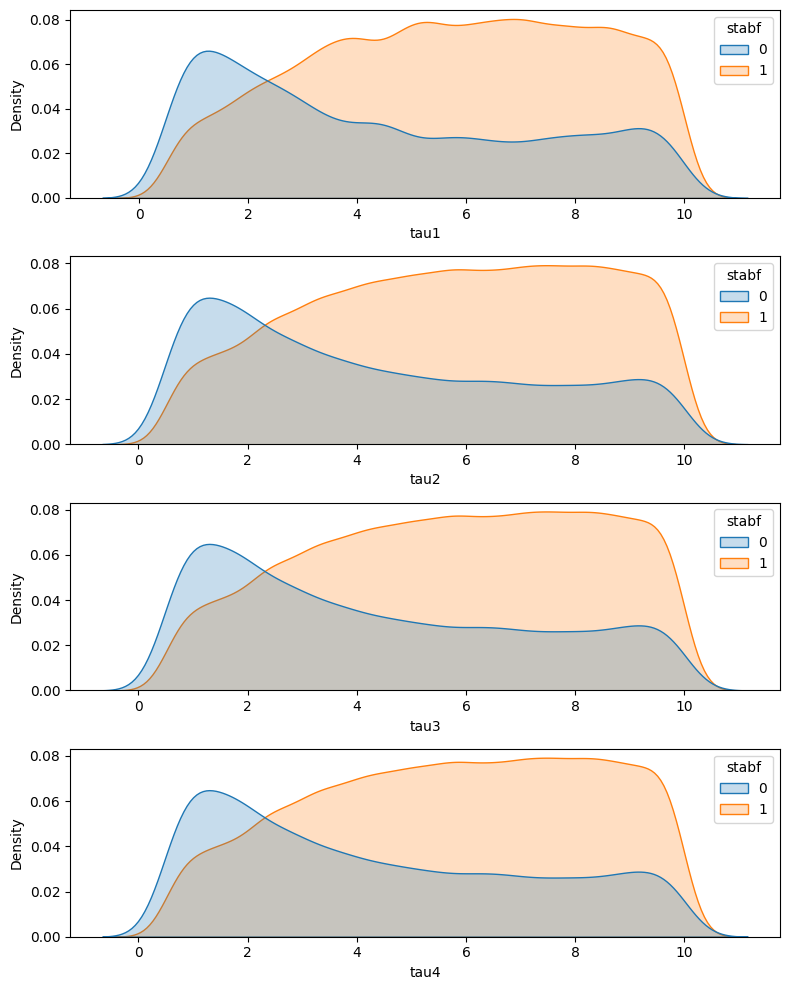

In [11]:
fig, axes = plt.subplots(4, 1, figsize=(8, 10))

sns.kdeplot(data=data, x="tau1", hue='stabf', fill=True, ax=axes[0])
sns.kdeplot(data=data, x="tau2", hue='stabf', fill=True, ax=axes[1])
sns.kdeplot(data=data, x="tau3", hue='stabf', fill=True, ax=axes[2])
sns.kdeplot(data=data, x="tau4", hue='stabf', fill=True, ax=axes[3])
plt.tight_layout()
plt.show()

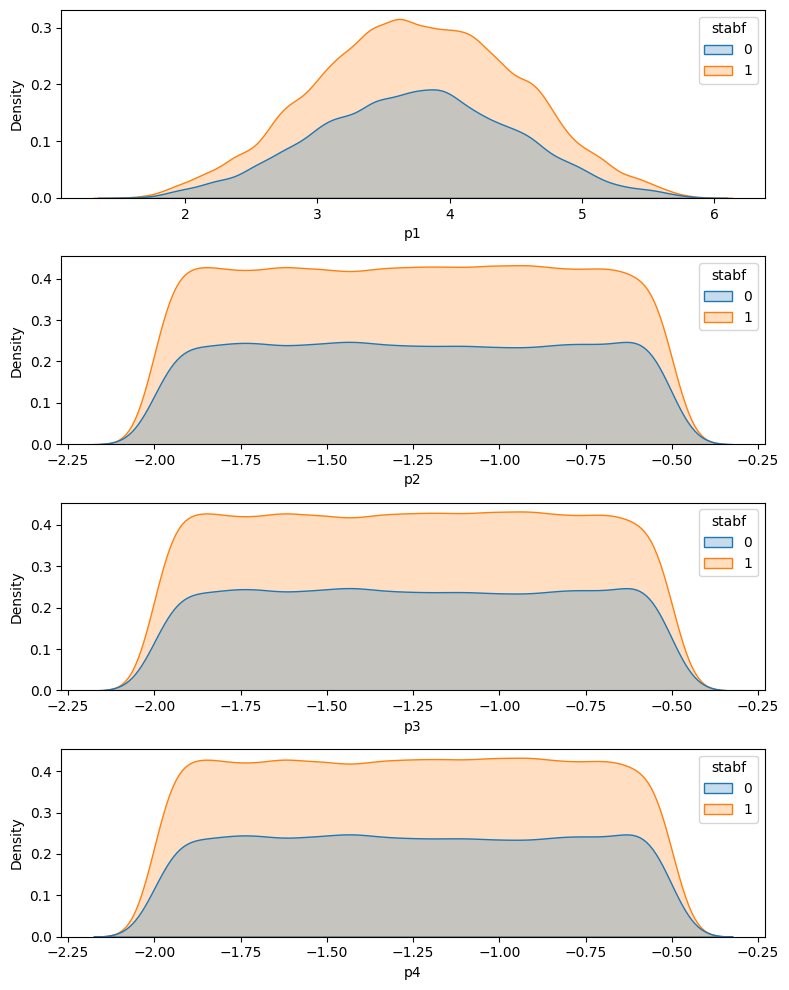

In [12]:
fig, axes = plt.subplots(4, 1, figsize=(8, 10))

sns.kdeplot(data=data, x="p1", hue='stabf', fill=True, ax=axes[0])
sns.kdeplot(data=data, x="p2", hue='stabf', fill=True, ax=axes[1])
sns.kdeplot(data=data, x="p3", hue='stabf', fill=True, ax=axes[2])
sns.kdeplot(data=data, x="p4", hue='stabf', fill=True, ax=axes[3])
plt.tight_layout()
plt.show()

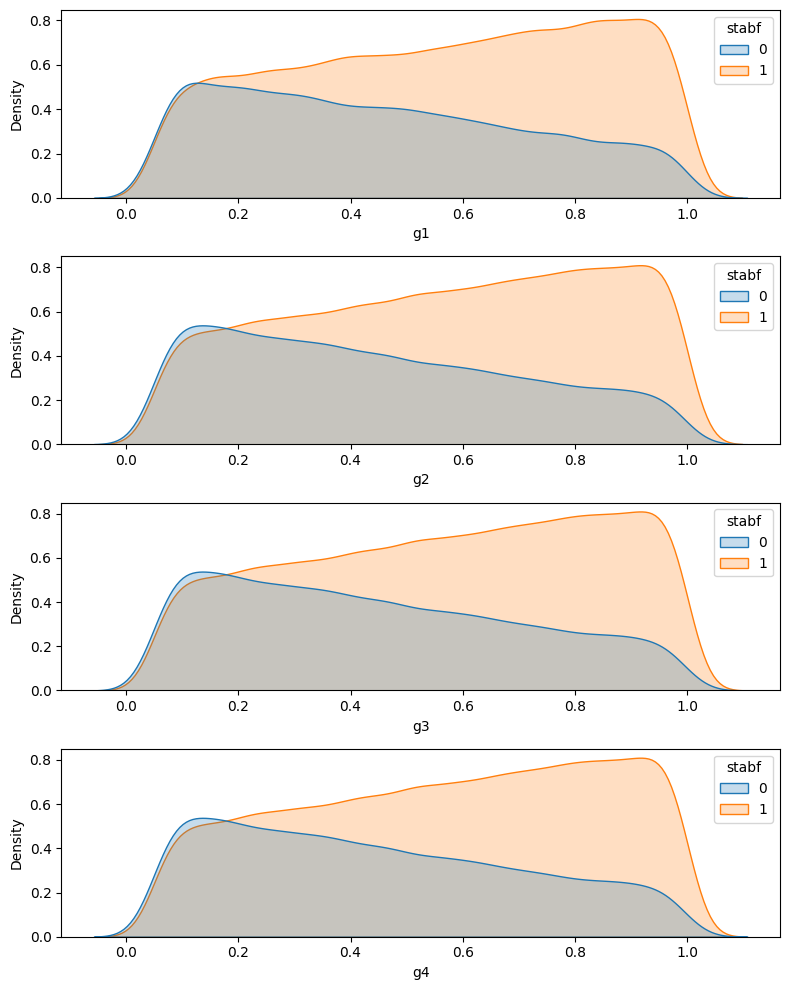

In [13]:
fig, axes = plt.subplots(4, 1, figsize=(8, 10))

sns.kdeplot(data=data, x="g1", hue='stabf', fill=True, ax=axes[0])
sns.kdeplot(data=data, x="g2", hue='stabf', fill=True, ax=axes[1])
sns.kdeplot(data=data, x="g3", hue='stabf', fill=True, ax=axes[2])
sns.kdeplot(data=data, x="g4", hue='stabf', fill=True, ax=axes[3])
plt.tight_layout()
plt.show()

What those distribution plots tell us ?

* It becomes increasingly evident that as participants' reaction times ("tau" values) grow larger, the likelihood of the grid being in an unstable state also increases.

* A similar pattern emerges with price elasticity ("g" values), where the grid's likelihood of being in an unstable state appears to rise as "g" values become larger.

* The power produced and consumed ("p" values) present a normal distribution.

### Power Generated vs Consumed

We know that in the theory of 4-node grid architecture, the total power generated by the generator node should be equal to the total power consumed by the participant nodes, let's see if this principle holds in our data.

In [14]:
df = data.copy()
# generated power is positive
df["Power generated"] = data["p1"]
# consumed power is negative
df["Power consumed"] = -(data["p2"] + data["p3"] + data["p4"])

<Axes: xlabel='Power generated', ylabel='Power consumed'>

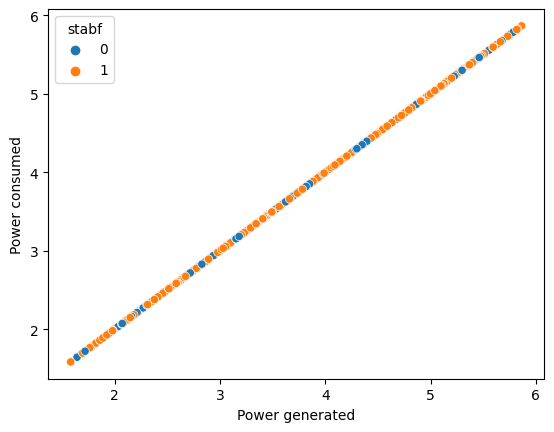

In [15]:
sns.scatterplot(data=df, y="Power consumed", x="Power generated", hue='stabf')

Indeed, we observe that the generated power aligns with the consumed power, even in instances where the grid is in an unstable state.

### Outliers Check

<Axes: >

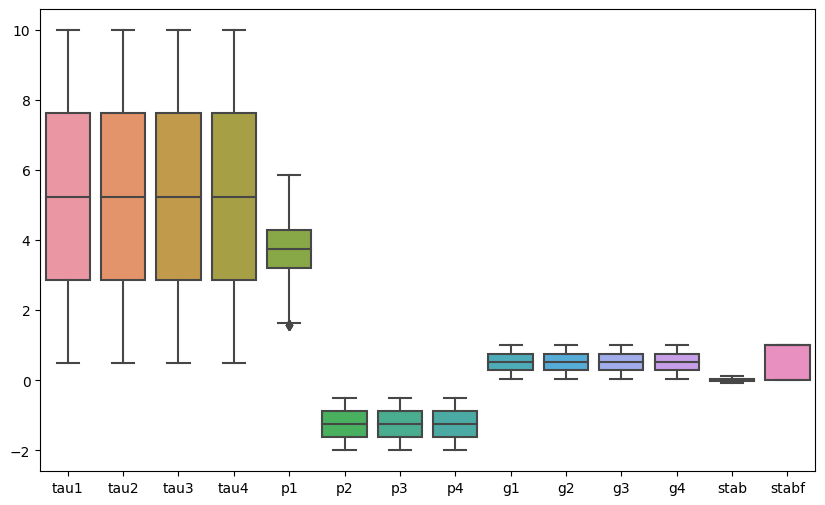

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(data)

With the exception of the 'p1' feature, which contains two outliers, all other features in the dataset are free of outlier values. We will leave these two outliers as their impact will be negligeable in our analysis.

### Correlation

<Axes: >

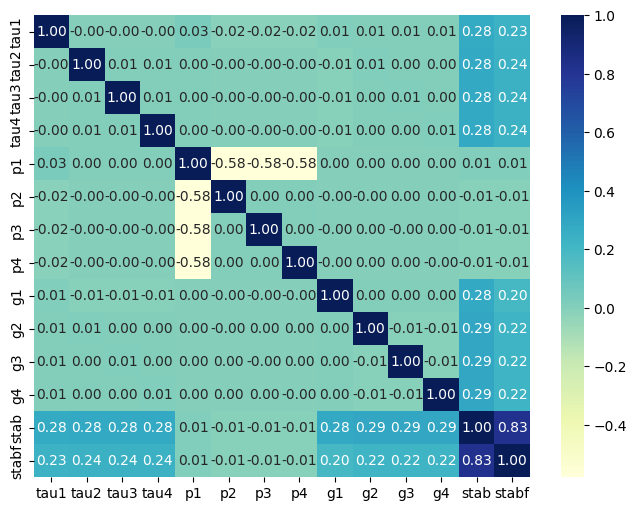

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), cmap='YlGnBu', fmt='.2f', annot=True)

We can see that :

1. As expected the 'stab' and 'stabf' fileds are highly correlated (as the later is derived from the former).
2. The reaction time ("tau" values) and price elasticity ("g" values) seems to have a small corrolation with the target 'stabf'.
3. The power produced/consumed ("p" values) doesn't present in relation with 'stabf'.

## Data Preprocessing

In [18]:
from sklearn.model_selection import train_test_split

# Split the dataset into 3 part : Training(80%), Testing(15%) and validation(5%)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=True, random_state=0)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.25, random_state=0)

In [19]:
from sklearn.preprocessing import StandardScaler

def scale_features(x_train, x_test, x_val):
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train =  scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    x_val = scaler.transform(x_val)
    return x_train, x_test, x_val

In [20]:
x_train, x_test, x_val = scale_features(x_train, x_test, x_val)

## Models Training

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [56]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score

metrics = {}
def accuracy_logs(y_test, y_pred, model=None):
    if model is not None:
        metrics[model] = [
          np.round(accuracy_score(y_test, y_pred), 3),
          np.round(precision_score(y_test, y_pred), 3),
          np.round(recall_score(y_test, y_pred), 3),
          np.round(f1_score(y_test, y_pred), 3)
        ]
    print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
    print("Metrics table:\n", classification_report(y_test, y_pred, target_names=["stable", "unstable"]))

def draw_confusion_matrix(y_test, y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    matrix = pd.DataFrame(matrix, index=['unstable', 'stable'], columns=['unstable', 'stable'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, cmap='YlGnBu', fmt='.2f', annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Real')

### Logistic Regression

In [64]:
lrg_clf = LogisticRegression()
lrg_clf.fit(x_train, y_train)
y_pred = lrg_clf.predict(x_test)

In [65]:
accuracy_logs(y_test, y_pred, "Logistic Regression")

accuracy_score: 0.8143333333333334
Metrics table:
               precision    recall  f1-score   support

      stable       0.76      0.71      0.73      3231
    unstable       0.84      0.87      0.86      5769

    accuracy                           0.81      9000
   macro avg       0.80      0.79      0.80      9000
weighted avg       0.81      0.81      0.81      9000



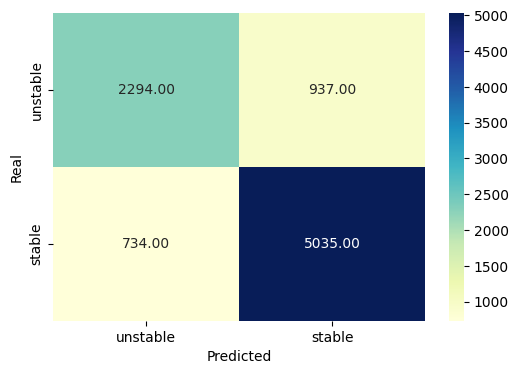

In [66]:
draw_confusion_matrix(y_test, y_pred)

### Decision Tree

In [67]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(x_train, y_train)
y_pred = tree_clf.predict(x_test)

In [68]:
accuracy_logs(y_test, y_pred, "Decision Tree")

accuracy_score: 0.9047777777777778
Metrics table:
               precision    recall  f1-score   support

      stable       0.88      0.86      0.87      3231
    unstable       0.92      0.93      0.93      5769

    accuracy                           0.90      9000
   macro avg       0.90      0.89      0.90      9000
weighted avg       0.90      0.90      0.90      9000



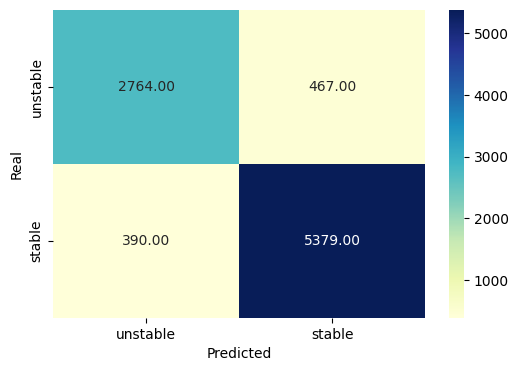

In [69]:
draw_confusion_matrix(y_test, y_pred)

### Random Forest Classifier

In [70]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)

In [71]:
accuracy_logs(y_test, y_pred, "Random Forest")

accuracy_score: 0.9493333333333334
Metrics table:
               precision    recall  f1-score   support

      stable       0.94      0.91      0.93      3231
    unstable       0.95      0.97      0.96      5769

    accuracy                           0.95      9000
   macro avg       0.95      0.94      0.94      9000
weighted avg       0.95      0.95      0.95      9000



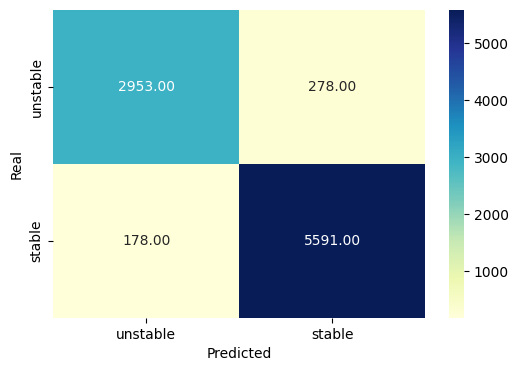

In [72]:
draw_confusion_matrix(y_test, y_pred)

### XGBoost Classifier

In [73]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train)
y_pred = xgb_clf.predict(x_test)

In [74]:
accuracy_logs(y_test, y_pred, "XGBoost")

accuracy_score: 0.9805555555555555
Metrics table:
               precision    recall  f1-score   support

      stable       0.98      0.97      0.97      3231
    unstable       0.98      0.99      0.98      5769

    accuracy                           0.98      9000
   macro avg       0.98      0.98      0.98      9000
weighted avg       0.98      0.98      0.98      9000



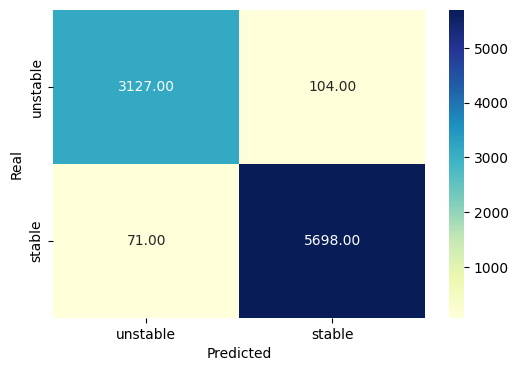

In [75]:
draw_confusion_matrix(y_test, y_pred)

### Support Vector Machine

In [76]:
svc_clf = SVC(random_state=0)
svc_clf.fit(x_train, y_train)
y_pred = svc_clf.predict(x_test)

In [77]:
accuracy_logs(y_test, y_pred, "SVC")

accuracy_score: 0.9795555555555555
Metrics table:
               precision    recall  f1-score   support

      stable       0.98      0.97      0.97      3231
    unstable       0.98      0.99      0.98      5769

    accuracy                           0.98      9000
   macro avg       0.98      0.98      0.98      9000
weighted avg       0.98      0.98      0.98      9000



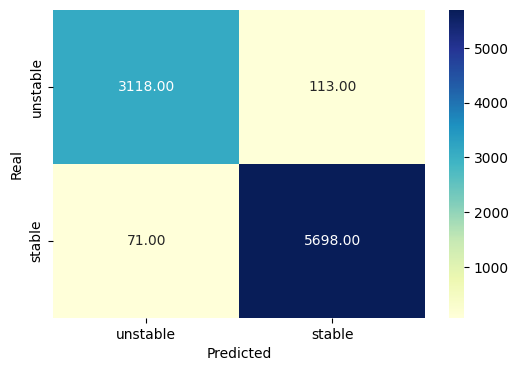

In [78]:
draw_confusion_matrix(y_test, y_pred)

In [43]:
pd.DataFrame(metrics, index=["Accuracy", "Precision", "Recall", "F1 score"]).T

,Accuracy,Precision,Recall,F1 score
Logistic Regression,0.814,0.843,0.873,0.858
Decision Tree,0.903,0.921,0.928,0.925
Random Forest,0.949,0.953,0.969,0.961
XGBoost,0.981,0.982,0.988,0.985
SVC,0.980,0.981,0.988,0.984


### Observations

* Every ML algorithm demonstrated a classification accuracy surpassing 90%, with the sole exception being the logistic regression model, which achieved only 81% accuracy.

* While all models resulted some false positive/negative predictions, XGBoost and SVC had the fewest instances. Even though their proportion is small, we should try to minimize these wrong predictions, particularly in cases of false negatives.

* Both the XGBoost and SVC models achieved the highest accuracy thus far, approximately 98%. Consequently, we will try to enhance their performance by fine-tuning their hyperparameters.

### Neural network

In [44]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout

In [45]:
model = Sequential()
model.add(Input(shape=(12,)))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [46]:
model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/15
1500/1500 [==============================] - 13s 4ms/step - loss: 0.2187 - accuracy: 0.9022 - val_loss: 0.1098 - val_accuracy: 0.9564
Epoch 2/15
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1315 - accuracy: 0.9440 - val_loss: 0.0933 - val_accuracy: 0.9613
Epoch 3/15
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1115 - accuracy: 0.9541 - val_loss: 0.0771 - val_accuracy: 0.9690
Epoch 4/15
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1044 - accuracy: 0.9573 - val_loss: 0.0740 - val_accuracy: 0.9709
Epoch 5/15
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0992 - accuracy: 0.9580 - val_loss: 0.0724 - val_accuracy: 0.9713
Epoch 6/15
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0922 - accuracy: 0.9613 - val_loss: 0.0745 - val_accuracy: 0.9701
Epoch 7/15
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0900 - accuracy: 0.9625 - val_loss: 0.0717 - val_accuracy

<Axes: >

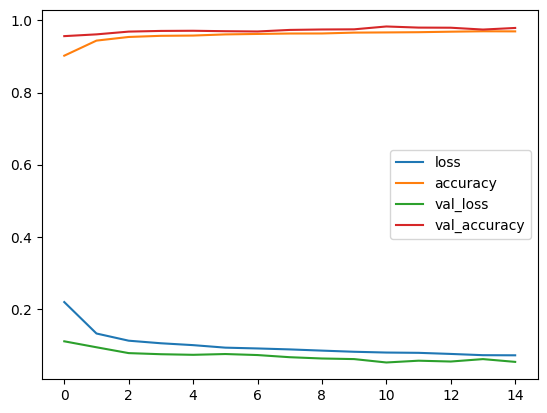

In [47]:
results = pd.DataFrame(model.history.history)
results.plot()

In [79]:
model_prediction = model.predict(x_test)
accuracy_logs(y_test, np.round(model_prediction), "Neural Net")

282/282 [==============================] - 1s 2ms/step
accuracy_score: 0.9791111111111112
Metrics table:
               precision    recall  f1-score   support

      stable       0.98      0.96      0.97      3231
    unstable       0.98      0.99      0.98      5769

    accuracy                           0.98      9000
   macro avg       0.98      0.97      0.98      9000
weighted avg       0.98      0.98      0.98      9000



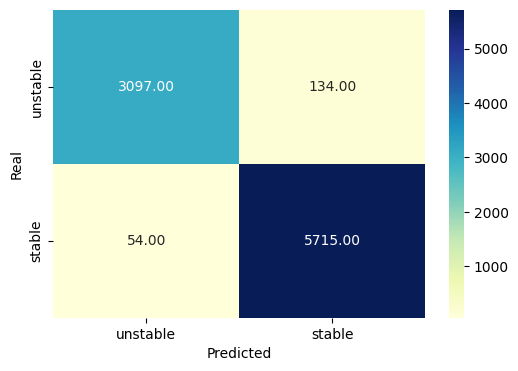

In [80]:
draw_confusion_matrix(y_test, np.round(model_prediction))

## Models Hyperparameters Tuning

Based on the preceding outcome, we found that the XGBoost and Support Vector Classifier (SVC) models demonstrated the highest accuracy among the ML models considered. Consequently, we will now try to fine-tune their parameters to see whether further enhancements in accuracy can be achieved.

### 1- XGBoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {
    'n_estimators': [50, 100, 200, 1000],
    'max_depth': range(3, 10),
    'min_child_weight': range(1, 6),
    'gamma': [i*0.1 for i in range(0, 5)],
    'reg_alpha':[1e-4, 1e-2, 0.1, 1]
}

xgb_tuned = RandomizedSearchCV(estimator=xgb_clf, param_distributions=random_grid, n_iter=50, cv=3, random_state=0, n_jobs=-1)

In [ ]:
xgb_tuned.fit(x_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'gamma': [0.0, 0.1, 0.2,
                                                  0.30000000000000004, 0.4],
                                        'max_depth': range(3, 10),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': [50, 100, 200, 1000],
                                        'reg_alpha': [0.0001, 0.01, 0.1, 1]},
                   random_state=0)

In [ ]:
print("Best Parameters:\n", xgb_tuned.best_params_)
print("Score with best Parameters: ", xgb_tuned.best_score_)

Best Parameters:
 {'reg_alpha': 0.01, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 0.0}
Score with best Parameters:  0.9844166666666667


In [81]:
params = {'n_estimators': 1000,
          'max_depth': 6,
          'min_child_weight': 1,
          'reg_alpha': 0.01,
          'gamma': 0.0
          }
xgb_tuned = XGBClassifier(**params)
xgb_tuned = xgb_tuned.fit(x_train, y_train)

In [82]:
y_pred = xgb_tuned.predict(x_test)
accuracy_logs(y_test, y_pred, "XGBoost Tuned")

accuracy_score: 0.9934444444444445
Metrics table:
               precision    recall  f1-score   support

      stable       0.99      0.99      0.99      3231
    unstable       0.99      1.00      0.99      5769

    accuracy                           0.99      9000
   macro avg       0.99      0.99      0.99      9000
weighted avg       0.99      0.99      0.99      9000



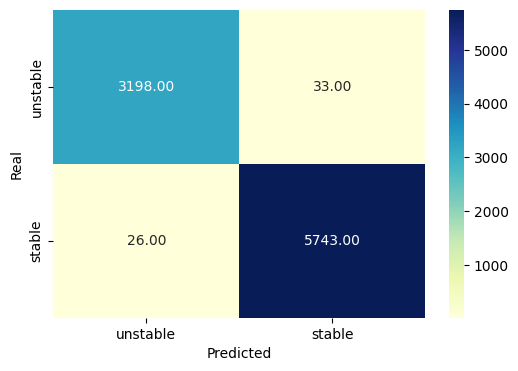

In [83]:
draw_confusion_matrix(y_test, y_pred)

#### Observation

The model accuracy has now reached 99.3%, and there has been a significant reduction in false positive/negative instances. Consequently, we deem this model sufficiently effective for our study and will proceed directly to the validation step.

### 2- SVC

In [ ]:
# svc_params = {'C': [0.1, 1, 10, 100],
#               'gamma': [1, 0.1, 0.01, 0.001]}

# tuned_svc = RandomizedSearchCV(estimator=svc_Cla, param_distributions=svc_params, n_iter=10, cv=3, random_state=0, n_jobs=-1)
# tuned_svc.fit(x_train, y_train)

In [ ]:
# print("Best Parameters:\n", xgb_tuned.best_params_)
# print("Score with best Parameters: ", xgb_tuned.best_score_)

In [ ]:
# y_pred = tuned_svc.predict(x_test)
# accuracy_logs(y_test, y_pred)

## Model Validation

After fine-tuning the XGBoost model parameters we got up to a 99.3% accuracy which is quit good and above the previous models result, we will now run both the tuned XGBoost model and the neural network (for reference) on the validation set split earlier.

Following the fine-tuning of the XGBoost model parameters, we achieved an impressive 99.4% accuracy, surpassing the performance of previous models. We will now proceed to evaluate both the tuned XGBoost model and the neural network (for reference) on the validation set that was partitioned earlier.

### 1- Neural network

In [57]:
val_prediction = np.round(model.predict(x_val))
accuracy_logs(y_val, val_prediction)

94/94 [==============================] - 0s 2ms/step
accuracy_score: 0.9796666666666667
Metrics table:
               precision    recall  f1-score   support

      stable       0.98      0.96      0.97      1060
    unstable       0.98      0.99      0.98      1940

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



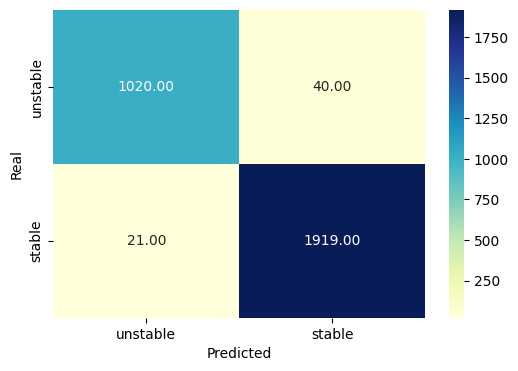

In [58]:
draw_confusion_matrix(y_val, val_prediction)

### 2- XGBoost Tuned

In [59]:
val_prediction = xgb_tuned.predict(x_val)
accuracy_logs(y_val, val_prediction)

accuracy_score: 0.992
Metrics table:
               precision    recall  f1-score   support

      stable       0.99      0.98      0.99      1060
    unstable       0.99      1.00      0.99      1940

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



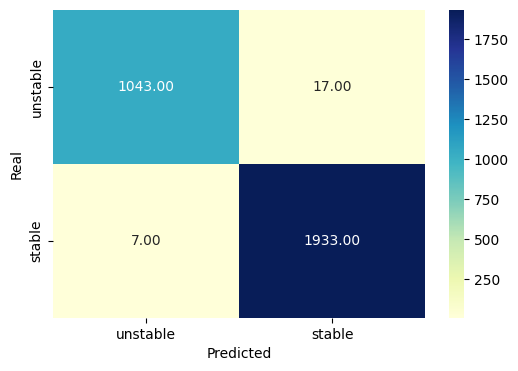

In [60]:
draw_confusion_matrix(y_val, val_prediction)

### Final Results

In [86]:
pd.DataFrame(metrics, index=["Accuracy", "Precision", "Recall", "F1 score"]).T.sort_values(by="Accuracy", ascending=False)

,Accuracy,Precision,Recall,F1 score
XGBoost Tuned,0.993,0.994,0.995,0.995
XGBoost,0.981,0.982,0.988,0.985
SVC,0.980,0.981,0.988,0.984
Neural Net,0.979,0.977,0.991,0.984
Random Forest,0.949,0.953,0.969,0.961
Decision Tree,0.905,0.920,0.932,0.926
Logistic Regression,0.814,0.843,0.873,0.858


## Conclusion

Through our study we tried to predict the stability of smart grids based on the DSGC model features, after building, training, testing various models we found that :

1. The majority of machine learning models, when trained and tested, exhibited remarkable accuracy, surpassing the 90% mark. Notably, Logistic Regression models were the exception, achieving only 81% accuracy.

2. Additionally, a deep learning model featuring simple dense layers demonstrated strong predictive capabilities, achieving an accuracy of 97%.

3. The hyperparameter tuning of the XGBoost classifier resulted in an exceptional higher accuracy of 99.3%, establishing it as the best performing prediction model in our study.

4. To further validate our findings, we confirmed the performance of the XGBoost model on the separate validation set and it consistently maintained a high level of accuracy at 99.2%.